In [1]:
# Import Statements

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import random
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
# Load in the data from .csv file
train_data = pd.read_csv('../input/nlp-getting-started/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Load in the data from .csv file
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')
test_data.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Text(0.5, 1.0, "Count of NaN's in data")

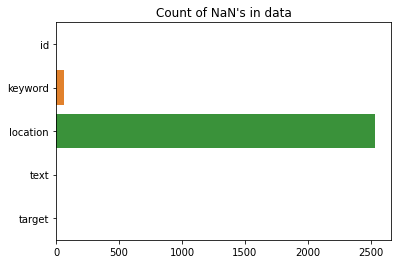

In [4]:
# Evaluate Missing Values
train_na_count = train_data.isna().sum()
sns.barplot(x=train_na_count.values, y=train_na_count.index)
plt.title("Count of NaN's in data")

In [5]:
train_data.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
test_data.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
train_data.count()


id          7613
keyword     7552
location    5080
text        7613
target      7613
dtype: int64

In [8]:
test_data.count()


id          3263
keyword     3237
location    2158
text        3263
dtype: int64

In [9]:
# Data Cleaning Train
#stripped = []
#for text in train_data['text'].values:
#        stripped.append(re.sub(r'https?://\S+|www\.\S+','',text))    # removing website link if any present in the text
#train_data['html_stripped'] = stripped

wl = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')
corpus = list()
for text in train_data['text'].values:
    text = re.sub(r'https?://\S+|www\.\S+','',text)    # removing website link if any present in the text 
    text = re.sub(r'[^a-zA-Z]', ' ', text)             # keeping only alphabetic characters
    text = text.lower()
    text = text.split()
    text = [wl.lemmatize(word) for word in text if not word in STOPWORDS]  # lemmatizing the words using wordnet lemmatizer
    text = " ".join(text)
    corpus.append(text)
train_data['preprocessed_data'] = corpus

In [10]:
train_data.head()

,id,keyword,location,text,target,preprocessed_data
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby alaska smoke wildfire pour...


In [11]:
# Data Cleaning Test
#stripped = []
#for text in test_data['text'].values:
#        stripped.append(re.sub(r'https?://\S+|www\.\S+','',text))    # removing website link if any present in the text
#test_data['html_stripped'] = stripped

corpus = list()
for text in test_data['text'].values:
    text = re.sub(r'https?://\S+|www\.\S+','',text)    # removing website link if any present in the text 
    text = re.sub(r'[^a-zA-Z]', ' ', text)             # keeping only alphabetic characters
    text = text.lower()
    text = text.split()
    text = [wl.lemmatize(word) for word in text if not word in STOPWORDS]  # lemmatizing the words using wordnet lemmatizer
    text = " ".join(text)
    corpus.append(text)
test_data['preprocessed_data'] = corpus

In [12]:
test_data.head()

,id,keyword,location,text,preprocessed_data
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",heard earthquake different city stay safe ever...
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond goose fleeing across str...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [13]:
# Create an empty model
nlp = spacy.blank("en")
# Create the TextCategorizer with exclusive classes and "bow" architecture
textcat = nlp.create_pipe(
              "textcat",
              config={
                "exclusive_classes": True,
                "architecture": "bow"})
# Add the TextCategorizer to the empty model
nlp.add_pipe(textcat)


In [14]:
# Add labels to text classifier
textcat.add_label("Disaster")
textcat.add_label("Not_Disaster")


1

In [15]:
train_texts = train_data['preprocessed_data'].values
train_labels = [{'cats': {'Disaster': target == 1,
                          'Not_Disaster': target == 0}} 
                for target in train_data['target']]
train_classifier_data = list(zip(train_texts, train_labels))

In [16]:
train_classifier_data[:20]

[('deed reason earthquake may allah forgive u',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('forest fire near la ronge sask canada',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('resident asked shelter place notified officer evacuation shelter place order expected',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('people receive wildfire evacuation order california',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('got sent photo ruby alaska smoke wildfire pours school',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('rockyfire update california hwy closed direction due lake county fire cafire wildfire',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('flood disaster heavy rain cause flash flooding street manitou colorado spring area',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('top hill see fire wood',
  {'cats': {'Disaster': True, 'Not_Disaster': False}}),
 ('emergency evacuation happening building acr

In [17]:
random.seed(1)
spacy.util.fix_random_seed(1)
optimizer = nlp.begin_training()
losses = {}
for epoch in range(500):
    random.shuffle(train_classifier_data)
    # Create the batch generator with batch size = 8
    batches = spacy.util.minibatch(train_classifier_data, size=8)
    # Iterate through minibatches
    for batch in batches:
        # Each batch is a list of (text, label) but we need to
        # send separate lists for texts and labels to update().
        # This is a quick way to split a list of tuples into lists
        texts, labels = zip(*batch)
        nlp.update(texts, labels, sgd=optimizer, losses=losses)
    print(losses)


{'textcat': 5.402231709798798}
{'textcat': 8.783880370639963}
{'textcat': 11.390192205115454}
{'textcat': 13.515880694714724}
{'textcat': 15.307462472577754}
{'textcat': 16.84630380794988}
{'textcat': 18.20043981046001}
{'textcat': 19.397528466893164}
{'textcat': 20.45850181275955}
{'textcat': 21.416457695939698}
{'textcat': 22.29576161111163}
{'textcat': 23.10356680572295}
{'textcat': 23.850255569683895}
{'textcat': 24.543920146447363}
{'textcat': 25.198166106376107}
{'textcat': 25.81824107984191}
{'textcat': 26.403551931656054}
{'textcat': 26.96428419106454}
{'textcat': 27.50376758823683}
{'textcat': 28.02052641126625}
{'textcat': 28.51604931705456}
{'textcat': 29.00443602119648}
{'textcat': 29.47823799245556}
{'textcat': 29.9345759980472}
{'textcat': 30.379190102896736}
{'textcat': 30.81402249968011}
{'textcat': 31.243850225903213}
{'textcat': 31.658495367390053}
{'textcat': 32.06956247102678}
{'textcat': 32.47072903649425}
{'textcat': 32.86665606864239}
{'textcat': 33.2560465585240

In [18]:
test_data['preprocessed_data'].values

array(['happened terrible car crash',
       'heard earthquake different city stay safe everyone',
       'forest fire spot pond goose fleeing across street cannot save',
       ..., 'green line derailment chicago',
       'meg issue hazardous weather outlook hwo',
       'cityofcalgary activated municipal emergency plan yycstorm'],
      dtype=object)

In [19]:
docs = [nlp.tokenizer(text) for text in test_data['preprocessed_data'].values]

In [20]:
docs[:20]

[happened terrible car crash,
 heard earthquake different city stay safe everyone,
 forest fire spot pond goose fleeing across street cannot save,
 apocalypse lighting spokane wildfire,
 typhoon soudelor kill china taiwan,
 shaking earthquake,
 probably still show life arsenal yesterday eh eh,
 hey,
 nice hat,
 fuck,
 like cold,
 nooooooooo,
 tell,
 ,
 awesome,
 birmingham wholesale market ablaze bbc news fire break birmingham wholesale market,
 sunkxssedharry wear short race ablaze,
 previouslyondoyintv toke makinwa marriage crisis set nigerian twitter ablaze,
 check nsfw,
 psa splitting personality techie follow ablaze co burner follow ablaze]

In [21]:
# Use textcat to get the scores for each doc
textcat = nlp.get_pipe('textcat')
scores, _ = textcat.predict(docs)
print(scores)


[[3.3082995e-01 6.6917008e-01]
 [8.7195075e-01 1.2804930e-01]
 [9.9998057e-01 1.9395806e-05]
 ...
 [9.7841644e-01 2.1583537e-02]
 [9.9374419e-01 6.2558781e-03]
 [9.8352814e-01 1.6471876e-02]]


In [22]:
scores.shape

(3263, 2)

In [23]:
# From the scores, find the label with the highest score/probability
predicted_labels = scores.argmax(axis=1)
#print([textcat.labels[label] for label in predicted_labels])
#['Disaster', 'Not_Disaster']
predicted_labels[:10]

array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [24]:
my_submission_v_1 = pd.DataFrame({'id':test_data['id'].values, 'target':predicted_labels})
my_submission_v_1.count()

id        3263
target    3263
dtype: int64

In [25]:
test_data['predicted_target'] = predicted_labels.tolist()

In [26]:
my_submission_v_1.to_csv('my_submission_v_1.6.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
